# Circle radius test
Learn the function $f: \mathbb{R}^{n} \rightarrow \mathbb{R}$ where $f:\bf{x} \mapsto |x|$ with a deep neural network and compute the mutual information changes between the input, the different layer outputs and the output.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.spatial as ss
from scipy.special import digamma
from math import log

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam

/home/mariosk/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_learning_curve(fitting_history):
    plt.clf()
    plt.figure(figsize=(10, 10))

    plt.subplot(2,1,1)
    plt.plot(fitting_history['loss'], color='steelblue')
    plt.plot(fitting_history['val_loss'], color='orange')
    plt.legend(['Training loss', 'Testing loss'])

    plt.subplot(2,1,2)
    plt.plot(fitting_history['acc'], color='steelblue')
    plt.plot(fitting_history['val_acc'], color='orange')
    plt.legend(['Training accuracy', 'Testing accuracy'])

    plt.show()

## Define function and generate random samples

In [3]:
def f(x):
    return np.where(np.sqrt(np.sum(x * x)) > 1.4, 1, 0)

In [4]:
np.random.seed(42)
X_train = np.random.uniform(-1, 1, size=[100000, 6])
Y_train = np.apply_along_axis(f, 1, X_train)

X_test = np.random.uniform(-1, 1, size=[10000, 6])
Y_test = np.apply_along_axis(f, 1, X_test)

In [5]:
pd.DataFrame(Y_train).describe()

,0
count,100000.000000
mean,0.503300
std,0.499992
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


## Normalized mutual information

In [6]:
def entropy(x, k=3, base=2, seed=None):
    assert k < len(x)
    d, N = len(x[0]), len(x)
    
    if seed:
        np.random.seed(seed)
    intens = 1e-10
    small_noise_x = x + intens * np.random.rand(d)
    
    tree = ss.cKDTree(small_noise_x)
    nn = tree.query(small_noise_x, k + 1, p=float('inf'), n_jobs=-1)[0][:, -1:]

    const = digamma(N) - digamma(k) + d * log(2)
    return (const + d * np.mean(np.log(nn))) / log(base)

In [7]:
def avg_digamma(points, dvec):
    N = len(points)
    tree = ss.cKDTree(points)
    avg = 0.
    
    for i in range(N):
        dist = dvec[i]
        num_points = len(tree.query_ball_point(points[i], dist - 1e-15, p=float('inf')))
        avg += digamma(num_points) / N
        
    return avg

In [8]:
def mutual_information(x, y, k=3, base=2, seed=None):
    assert len(x) == len(y), "Lists should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    
    if seed:
        np.random.seed(seed)
    intens = 1e-10
    x_noise = x + intens * np.random.rand(len(x[0]))
    y_noise = y + intens * np.random.rand(len(y[0]))
    points = np.concatenate([x_noise, y_noise], axis=1)
                   
    tree = ss.cKDTree(points)
    dvec = tree.query(points, k + 1, p=float('inf'), n_jobs=-1)[0][:, -1:]
       
    a, b, c, d = avg_digamma(x, dvec), avg_digamma(y, dvec), digamma(k), digamma(len(x))
    return (-a - b + c + d) / log(base)

In [42]:
def discrete_entropy(x):
    x_df = pd.DataFrame(x)
    probabilities = (x_df
        .reset_index()
        .groupby(list(x_df.columns))
        .count()) / x.shape[0]
    
    return - np.sum(probabilities * np.log2(probabilities))[0]

In [147]:
def mixed_mutual_information(x, y, k=3, base=2, seed=None):
    overallentropy = entropy(x, k, base, seed=seed)

    n = len(y)
    word_dict = dict()
    for i in range(len(y)):
        if type(y[i]) == list:
            y[i] = tuple(y[i])
    for sample in y:
        word_dict[sample] = word_dict.get(sample, 0) + 1. / n
    yvals = list(set(word_dict.keys()))

    mi = overallentropy
    for yval in yvals:
        xgiveny = [x[i] for i in range(n) if y[i] == yval]
        mi -= word_dict[yval] * entropy(xgiveny, k, base, seed=seed)
    return np.abs(mi)

## Build a feed forward neural network

In [330]:
ffnn = Sequential([
    Dense(48, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(24, activation='relu'),
    Dense(12, activation='relu'),
    Dense(10, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='sigmoid')
])

ffnn.compile(metrics=['accuracy'], optimizer=Adam(), loss='categorical_crossentropy')

In [331]:
number_of_epochs = 500
batch_size = 1000

ffnn_fitting = ffnn.fit(
    X_train, 
    to_categorical(Y_train),
    validation_data=(X_test, to_categorical(Y_test)),
    epochs=number_of_epochs,
    batch_size=batch_size)

Train on 100000 samples, validate on 10000 samples
Epoch 1/500
100000/100000 [==============================] - 1s 8us/step - loss: 0.6509 - acc: 0.5433 - val_loss: 0.5312 - val_acc: 0.7433
Epoch 2/500
100000/100000 [==============================] - 0s 5us/step - loss: 0.4089 - acc: 0.8935 - val_loss: 0.3561 - val_acc: 0.9420
Epoch 3/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.3307 - acc: 0.9547 - val_loss: 0.3179 - val_acc: 0.9560
Epoch 4/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.2984 - acc: 0.9639 - val_loss: 0.2896 - val_acc: 0.9635
Epoch 5/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.2735 - acc: 0.9682 - val_loss: 0.2706 - val_acc: 0.9632
Epoch 6/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.2536 - acc: 0.9702 - val_loss: 0.2522 - val_acc: 0.9668
Epoch 7/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.2364 - acc: 0.9724 - val_loss: 0

Epoch 59/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0426 - acc: 0.9858 - val_loss: 0.0571 - val_acc: 0.9783
Epoch 60/500
100000/100000 [==============================] - 0s 5us/step - loss: 0.0402 - acc: 0.9866 - val_loss: 0.0530 - val_acc: 0.9808
Epoch 61/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0418 - acc: 0.9857 - val_loss: 0.0549 - val_acc: 0.9806
Epoch 62/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0423 - acc: 0.9857 - val_loss: 0.0543 - val_acc: 0.9797
Epoch 63/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0384 - acc: 0.9875 - val_loss: 0.0518 - val_acc: 0.9799
Epoch 64/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0388 - acc: 0.9867 - val_loss: 0.0533 - val_acc: 0.9798
Epoch 65/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0388 - acc: 0.9865 - val_loss: 0.0522 - val_acc: 0.9803
Epoch 66/500
100000/

100000/100000 [==============================] - 0s 4us/step - loss: 0.0266 - acc: 0.9890 - val_loss: 0.0429 - val_acc: 0.9838
Epoch 176/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0257 - acc: 0.9896 - val_loss: 0.0452 - val_acc: 0.9821
Epoch 177/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0251 - acc: 0.9899 - val_loss: 0.0426 - val_acc: 0.9818
Epoch 178/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0242 - acc: 0.9902 - val_loss: 0.0449 - val_acc: 0.9809
Epoch 179/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0247 - acc: 0.9900 - val_loss: 0.0433 - val_acc: 0.9823
Epoch 180/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0256 - acc: 0.9899 - val_loss: 0.0457 - val_acc: 0.9807
Epoch 181/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0234 - acc: 0.9908 - val_loss: 0.0437 - val_acc: 0.9824
Epoch 182/500
100000/100000

100000/100000 [==============================] - 0s 4us/step - loss: 0.0214 - acc: 0.9914 - val_loss: 0.0431 - val_acc: 0.9831
Epoch 292/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0232 - acc: 0.9900 - val_loss: 0.0436 - val_acc: 0.9836
Epoch 293/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0232 - acc: 0.9908 - val_loss: 0.0545 - val_acc: 0.9774
Epoch 294/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0219 - acc: 0.9911 - val_loss: 0.0422 - val_acc: 0.9826
Epoch 295/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0224 - acc: 0.9907 - val_loss: 0.0552 - val_acc: 0.9799
Epoch 296/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0242 - acc: 0.9901 - val_loss: 0.0486 - val_acc: 0.9814
Epoch 297/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0216 - acc: 0.9912 - val_loss: 0.0409 - val_acc: 0.9838
Epoch 298/500
100000/100000

100000/100000 [==============================] - 0s 4us/step - loss: 0.0196 - acc: 0.9920 - val_loss: 0.0426 - val_acc: 0.9839
Epoch 408/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0210 - acc: 0.9912 - val_loss: 0.0497 - val_acc: 0.9815
Epoch 409/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0190 - acc: 0.9922 - val_loss: 0.0449 - val_acc: 0.9831
Epoch 410/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0207 - acc: 0.9914 - val_loss: 0.0462 - val_acc: 0.9812
Epoch 411/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0190 - acc: 0.9923 - val_loss: 0.0445 - val_acc: 0.9829
Epoch 412/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0196 - acc: 0.9918 - val_loss: 0.0460 - val_acc: 0.9819
Epoch 413/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0196 - acc: 0.9919 - val_loss: 0.0473 - val_acc: 0.9830
Epoch 414/500
100000/100000

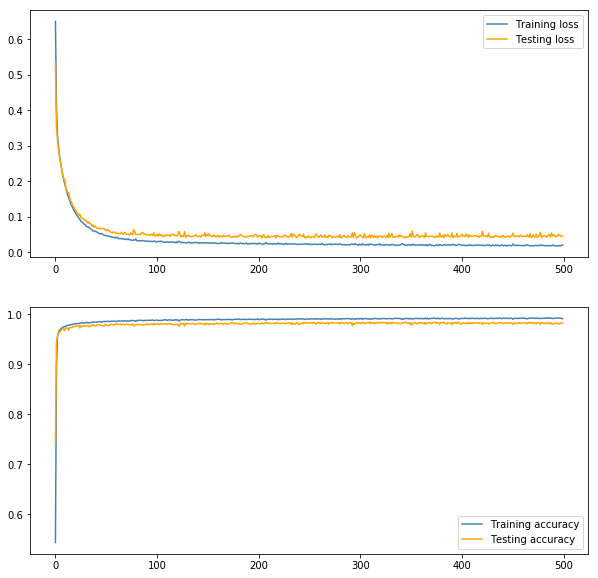

In [332]:
plot_learning_curve(ffnn_fitting.history)